# Climate Report: Little Rock, AR vs. Wellington, NZ (Imperial Units)

## Overview
This notebook compares the seasonal weather patterns of **Little Rock, Arkansas** and **Wellington, New Zealand** over the last 5 years.

**Note:** All units have been converted to Imperial standards per request:
* **Temperature:** Fahrenheit (°F)
* **Wind:** Miles per Hour (mph)
* **Precipitation:** Inches

### Metrics Analyzed
1.  **Temperature:** Averages, Variance, Standard Deviation, and Covariance.
2.  **Precipitation:** Average Daily Rain and Snow (inches).
3.  **Wind:** Average Daily Maximum Wind Speed (mph).
4.  **Severe Weather:** Thunderstorm Frequency.

**Data Source:** Open-Meteo Historical Weather API.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuration
plt.style.use('seaborn-v0_8')
%matplotlib inline
sns.set_palette("tab10")

## 1. Data Extraction (Imperial Units)
We fetch daily weather data from the **Open-Meteo API**, specifically requesting Fahrenheit, mph, and Inches.

In [2]:
# 1. Define Locations
locations = {
    "Little Rock, AR": {"lat": 34.7445, "lon": -92.2880, "hemisphere": "North"},
    "Wellington, NZ":  {"lat": -41.2865, "lon": 174.7762, "hemisphere": "South"}
}

end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')

# 2. Data Fetching Function
def get_weather_data(lat, lon, city, start, end):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,
        "end_date": end,
        "daily": [
            "temperature_2m_max", "temperature_2m_min", 
            "wind_speed_10m_max", "rain_sum", 
            "snowfall_sum", "weather_code"
        ],
        "temperature_unit": "fahrenheit",   # Requesting F
        "wind_speed_unit": "mph",           # Requesting mph
        "precipitation_unit": "inch",       # Requesting inches
        "timezone": "auto"
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame({
        'Date': pd.to_datetime(data['daily']['time']),
        'Max_Temp': data['daily']['temperature_2m_max'],
        'Min_Temp': data['daily']['temperature_2m_min'],
        'Wind_Speed': data['daily']['wind_speed_10m_max'],
        'Rain': data['daily']['rain_sum'],
        'Snow': data['daily']['snowfall_sum'],
        'Weather_Code': data['daily']['weather_code']
    })
    
    # Calculate Average Temp
    df['Avg_Temp'] = (df['Max_Temp'] + df['Min_Temp']) / 2
    
    # Detect Thunderstorms (WMO codes: 95, 96, 99)
    df['Is_Thunderstorm'] = df['Weather_Code'].isin([95, 96, 99]).astype(int)
    
    df['City'] = city
    return df

# 3. Build Dataset
dfs = []
for city, coords in locations.items():
    print(f"Fetching data for {city}...")
    df = get_weather_data(coords['lat'], coords['lon'], city, start_date, end_date)
    df['Hemisphere'] = coords['hemisphere']
    dfs.append(df)

weather_df = pd.concat(dfs).reset_index(drop=True)
weather_df.head()

Fetching data for Little Rock, AR...
Fetching data for Wellington, NZ...


,Date,Max_Temp,Min_Temp,Wind_Speed,Rain,Snow,Weather_Code,Avg_Temp,Is_Thunderstorm,City,Hemisphere
0,2020-11-19,69.3,47.0,12.2,0.000,0.0,0,58.15,0,"Little Rock, AR",North
1,2020-11-20,70.7,53.5,9.2,0.000,0.0,3,62.10,0,"Little Rock, AR",North
2,2020-11-21,71.2,55.4,6.2,0.008,0.0,51,63.30,0,"Little Rock, AR",North
3,2020-11-22,62.4,42.9,12.5,0.185,0.0,61,52.65,0,"Little Rock, AR",North
4,2020-11-23,55.1,35.8,6.3,0.000,0.0,3,45.45,0,"Little Rock, AR",North


## 2. Seasonal Processing
Assigning seasons based on hemisphere (North vs South).

In [3]:
def get_season(row):
    m = row['Date'].month
    h = row['Hemisphere']
    
    if m in [12, 1, 2]: return 'Winter' if h == 'North' else 'Summer'
    elif m in [3, 4, 5]: return 'Spring' if h == 'North' else 'Fall'
    elif m in [6, 7, 8]: return 'Summer' if h == 'North' else 'Winter'
    else: return 'Fall' if h == 'North' else 'Spring'

weather_df['Season'] = weather_df.apply(get_season, axis=1)
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

## 3. Temperature Analysis (°F)
We calculate the Mean, Standard Deviation (Volatility), and Variance.

In [4]:
temp_stats = weather_df.groupby(['City', 'Season'])['Avg_Temp'].agg(['mean', 'std', 'var'])
temp_stats = temp_stats.reindex(pd.MultiIndex.from_product([weather_df['City'].unique(), season_order], names=['City', 'Season']))

print("Temperature Statistics (°F):")
display(temp_stats.style.format("{:.2f}").background_gradient(subset=['std'], cmap='Reds'))

Temperature Statistics (°F):


## 4. Environmental Analysis
Here we analyze:
1.  **Wind Speed (mph):** Average daily maximum.
2.  **Rain (inches):** Average daily rainfall.
3.  **Snow (inches):** Average daily snowfall.
4.  **Thunderstorm Frequency:** Percentage of days with thunderstorms.

In [9]:
# Aggregate Environmental Data
env_stats = weather_df.groupby(['City', 'Season']).agg({
    'Wind_Speed': 'mean',
    'Rain': 'mean',
    'Snow': 'mean',
    'Is_Thunderstorm': 'mean'
})

# Convert decimal probability to Percentage for Thunderstorms
env_stats['Is_Thunderstorm'] = env_stats['Is_Thunderstorm'] * 100
env_stats.rename(columns={'Is_Thunderstorm': 'T-Storm freq(%)'}, inplace=True)

# Reorder
env_stats = env_stats.reindex(pd.MultiIndex.from_product([weather_df['City'].unique(), season_order], names=['City', 'Season']))

print("Environmental Averages (Imperial Units):")
display(env_stats.style.format("{:.2f}").background_gradient(cmap='Blues'))

Environmental Averages (Imperial Units):


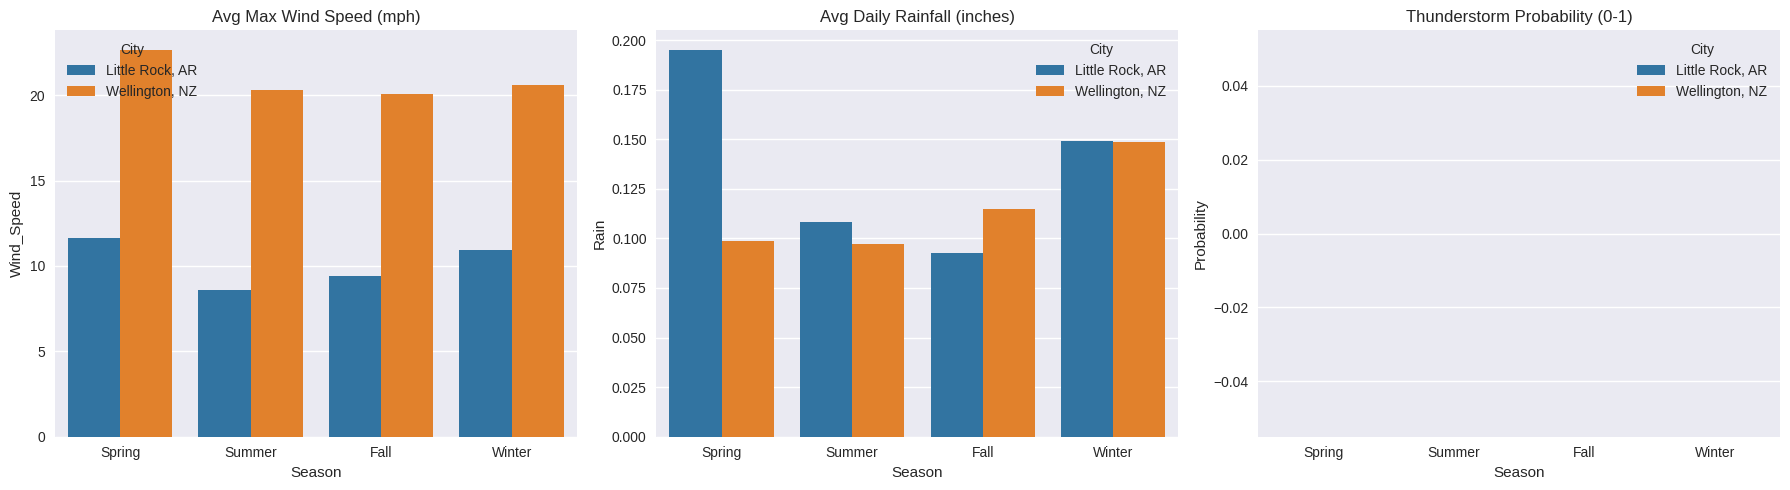

In [10]:
# Visualization of Environmental Factors
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=weather_df, x='Season', y='Wind_Speed', hue='City', ax=axes[0], order=season_order, errorbar=None)
axes[0].set_title("Avg Max Wind Speed (mph)")

sns.barplot(data=weather_df, x='Season', y='Rain', hue='City', ax=axes[1], order=season_order, errorbar=None)
axes[1].set_title("Avg Daily Rainfall (inches)")

sns.barplot(data=weather_df, x='Season', y='Is_Thunderstorm', hue='City', ax=axes[2], order=season_order, errorbar=None)
axes[2].set_title("Thunderstorm Probability (0-1)")
axes[2].set_ylabel("Probability")

plt.tight_layout()
plt.show()

## 5. Covariance Analysis
1.  **Cross-City:** How Little Rock temps relate to Wellington temps (expected negative).
2.  **Daily Spread:** How Daily Highs relate to Daily Lows within the same city.

In [11]:
# Cross-Location Covariance
pivot = weather_df.pivot(index='Date', columns='City', values='Avg_Temp')
loc_cov = pivot.cov()

print("Covariance: Little Rock vs Wellington (Avg Temp)")
display(loc_cov)

print("\nCovariance: Daily Highs vs Lows (Within City)")
for city in locations.keys():
    subset = weather_df[weather_df['City'] == city]
    cov_val = np.cov(subset['Max_Temp'], subset['Min_Temp'])[0][1]
    print(f"{city}: {cov_val:.2f}")

Covariance: Little Rock vs Wellington (Avg Temp)


City,"Little Rock, AR","Wellington, NZ"
City,,
"Little Rock, AR",263.958736,-61.413516
"Wellington, NZ",-61.413516,29.580002



Covariance: Daily Highs vs Lows (Within City)
Little Rock, AR: 256.18
Wellington, NZ: 27.06


## 6. 5-Year Temperature Trends (°F)
Visualizing the average highs and lows over time.

/tmp/ipykernel_12058/1198570486.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = weather_df.groupby(['City', pd.Grouper(key='Date', freq='M')]).agg({'Max_Temp':'mean', 'Min_Temp':'mean'}).reset_index()


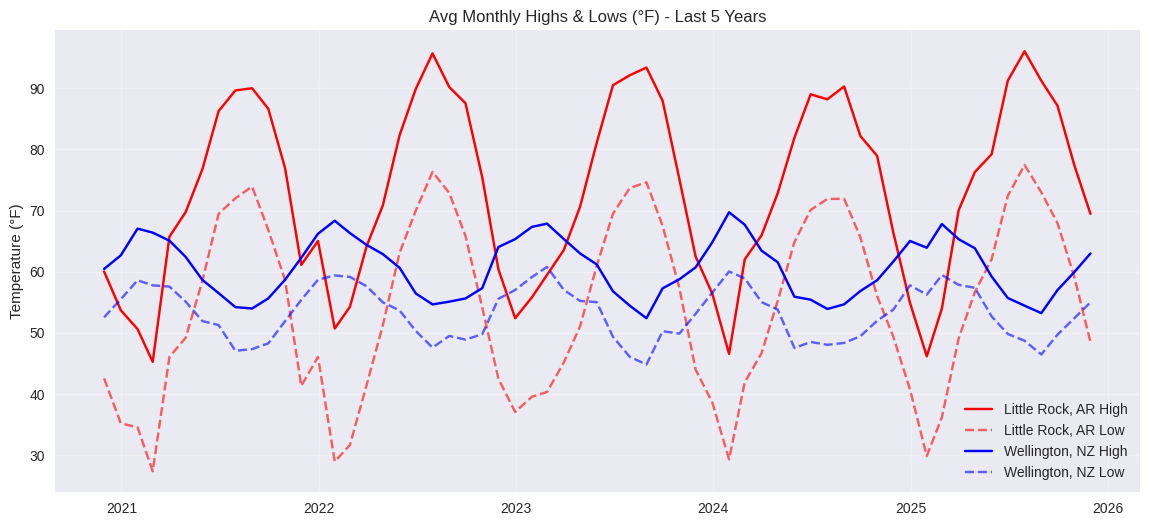

In [12]:
plt.figure(figsize=(14, 6))

# Resample to Monthly Mean for cleaner visualization
monthly = weather_df.groupby(['City', pd.Grouper(key='Date', freq='M')]).agg({'Max_Temp':'mean', 'Min_Temp':'mean'}).reset_index()

colors = {'Little Rock, AR': 'red', 'Wellington, NZ': 'blue'}

for city in locations.keys():
    subset = monthly[monthly['City'] == city]
    plt.plot(subset['Date'], subset['Max_Temp'], label=f'{city} High', color=colors[city], linestyle='-')
    plt.plot(subset['Date'], subset['Min_Temp'], label=f'{city} Low', color=colors[city], linestyle='--', alpha=0.6)

plt.title('Avg Monthly Highs & Lows (°F) - Last 5 Years')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()